In [1]:
import os

import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
sns.set_context('notebook')

import sklearn
from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import pairwise_distances
from sklearn import datasets

import scipy
from scipy.spatial.distance import pdist
from scipy.linalg import eigh
from scipy.spatial.distance import euclidean

import graphtools
#from pydiffmap.diffusion_map import DiffusionMap
import phate

In [2]:
def plot_embeddings_1000G_labels(emb, labels, palette, label_order, ax):
    
    sns.scatterplot(x=emb[:,0],
                    y=emb[:,1],
                    ax=ax,
                    palette=palette,
                    hue_order=label_order,
                    hue=pd.Categorical(labels))
    ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')

    for label in np.unique(labels):
        index = label == labels
        mean_pos = emb[index,:2].mean(0)
        ax.text(x=mean_pos[0], 
                y=mean_pos[1], 
                s=label)

## 1000G

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs = hf['inputs'][:]
    class_label_names = hf['class_label_names'][:]
    class_labels = hf['class_labels'][:]
    samples = hf['samples'][:]
    snp_names = hf['snp_names'][:]
    
# make labels
label_with_names = [str(class_label_names[y])[2:-1] for y in class_labels]
class_label_names = [str(label)[2:-1] for label in class_label_names]

label_with_superpop_names = np.zeros_like(label_with_names)
for label in mappings.super_pops_1000G:
    index = pd.DataFrame(label_with_names).isin(mappings.super_pops_1000G[label]).values.flatten()
    label_with_superpop_names[index] = label

This time we include all the groups

In [6]:
idx_to_use = label_with_superpop_names != 'AMR'

label_with_superpop_names = label_with_superpop_names[idx_to_use]
inputs = inputs[idx_to_use]  
samples = samples[idx_to_use] 
label_with_names = np.array(label_with_names)[idx_to_use]

In [7]:
# For visualization of diffusion operator, will want to order by class!
new_order = []
labs_arr = np.array(label_with_names)
for lab in mappings.label_order_1000G_fine:
    new_order = new_order + np.arange(len(labs_arr))[lab == labs_arr].tolist()

In [8]:
# initial phate embedding
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

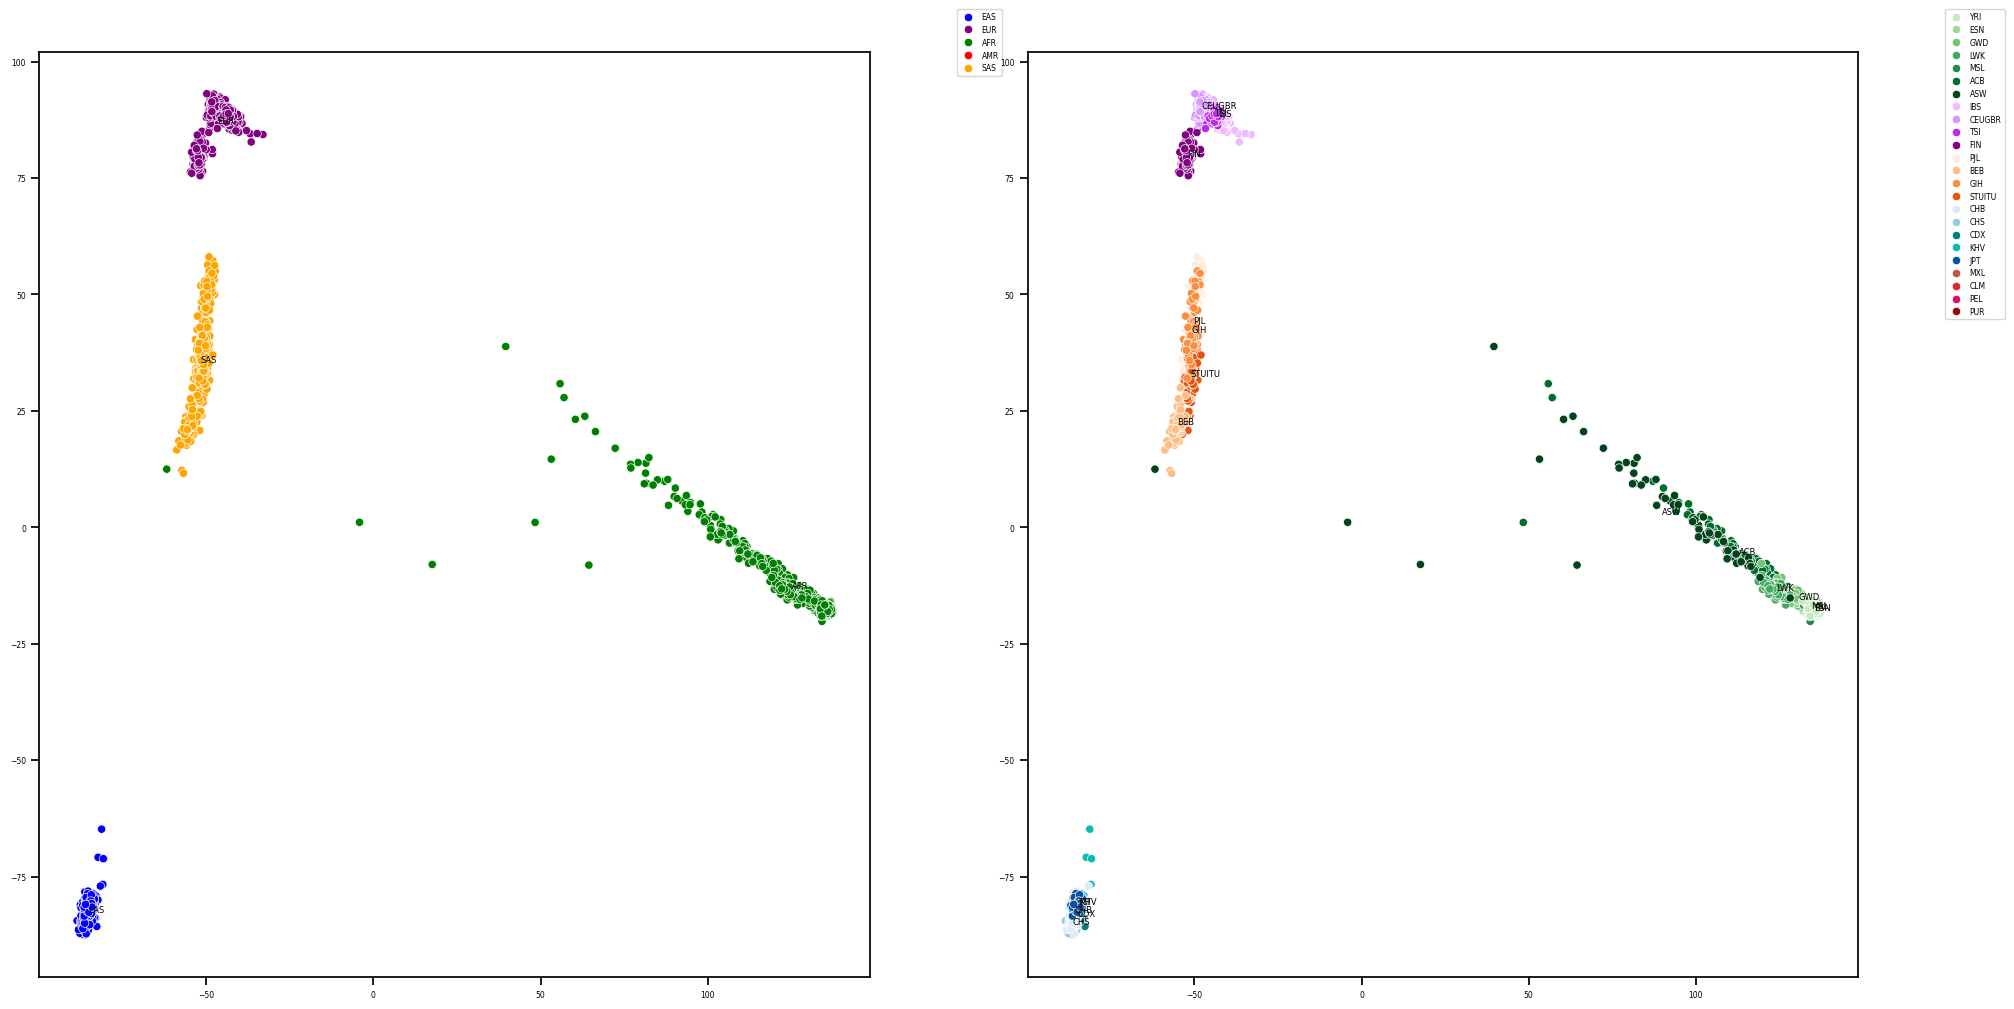

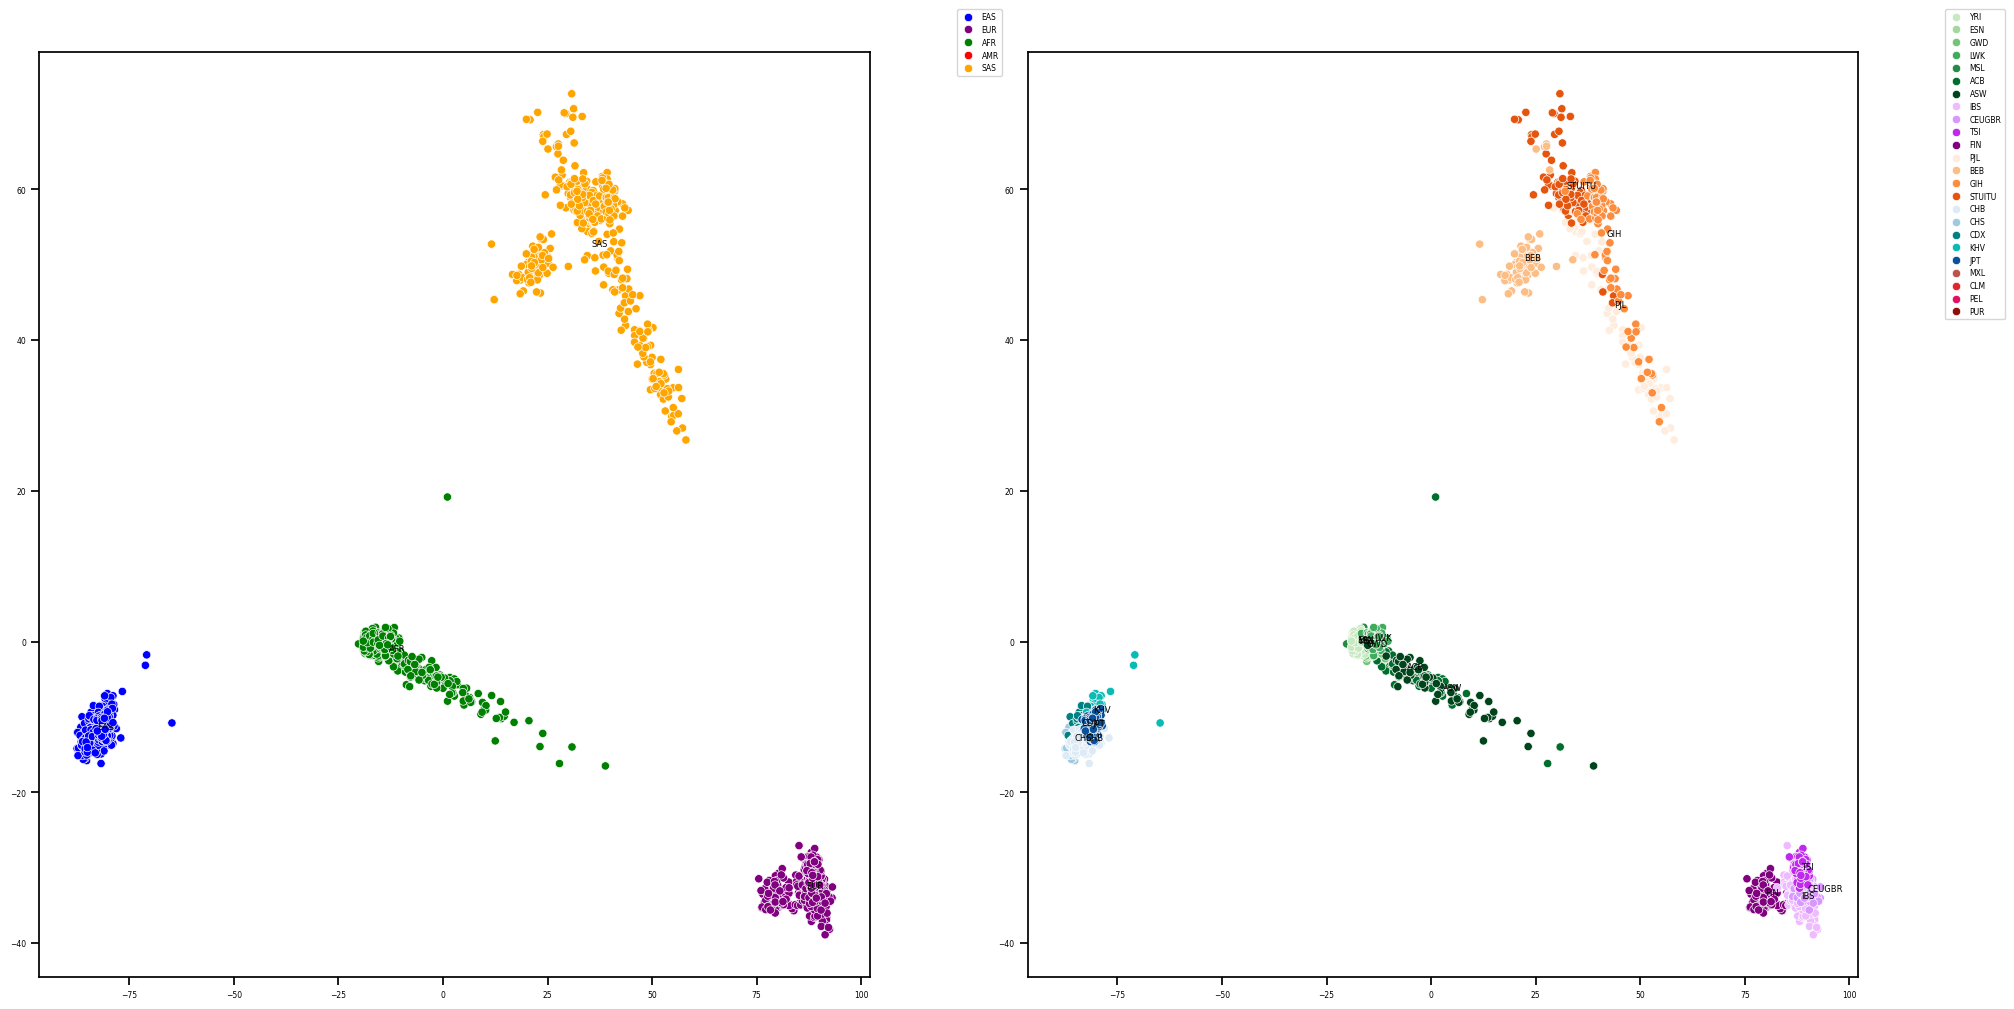

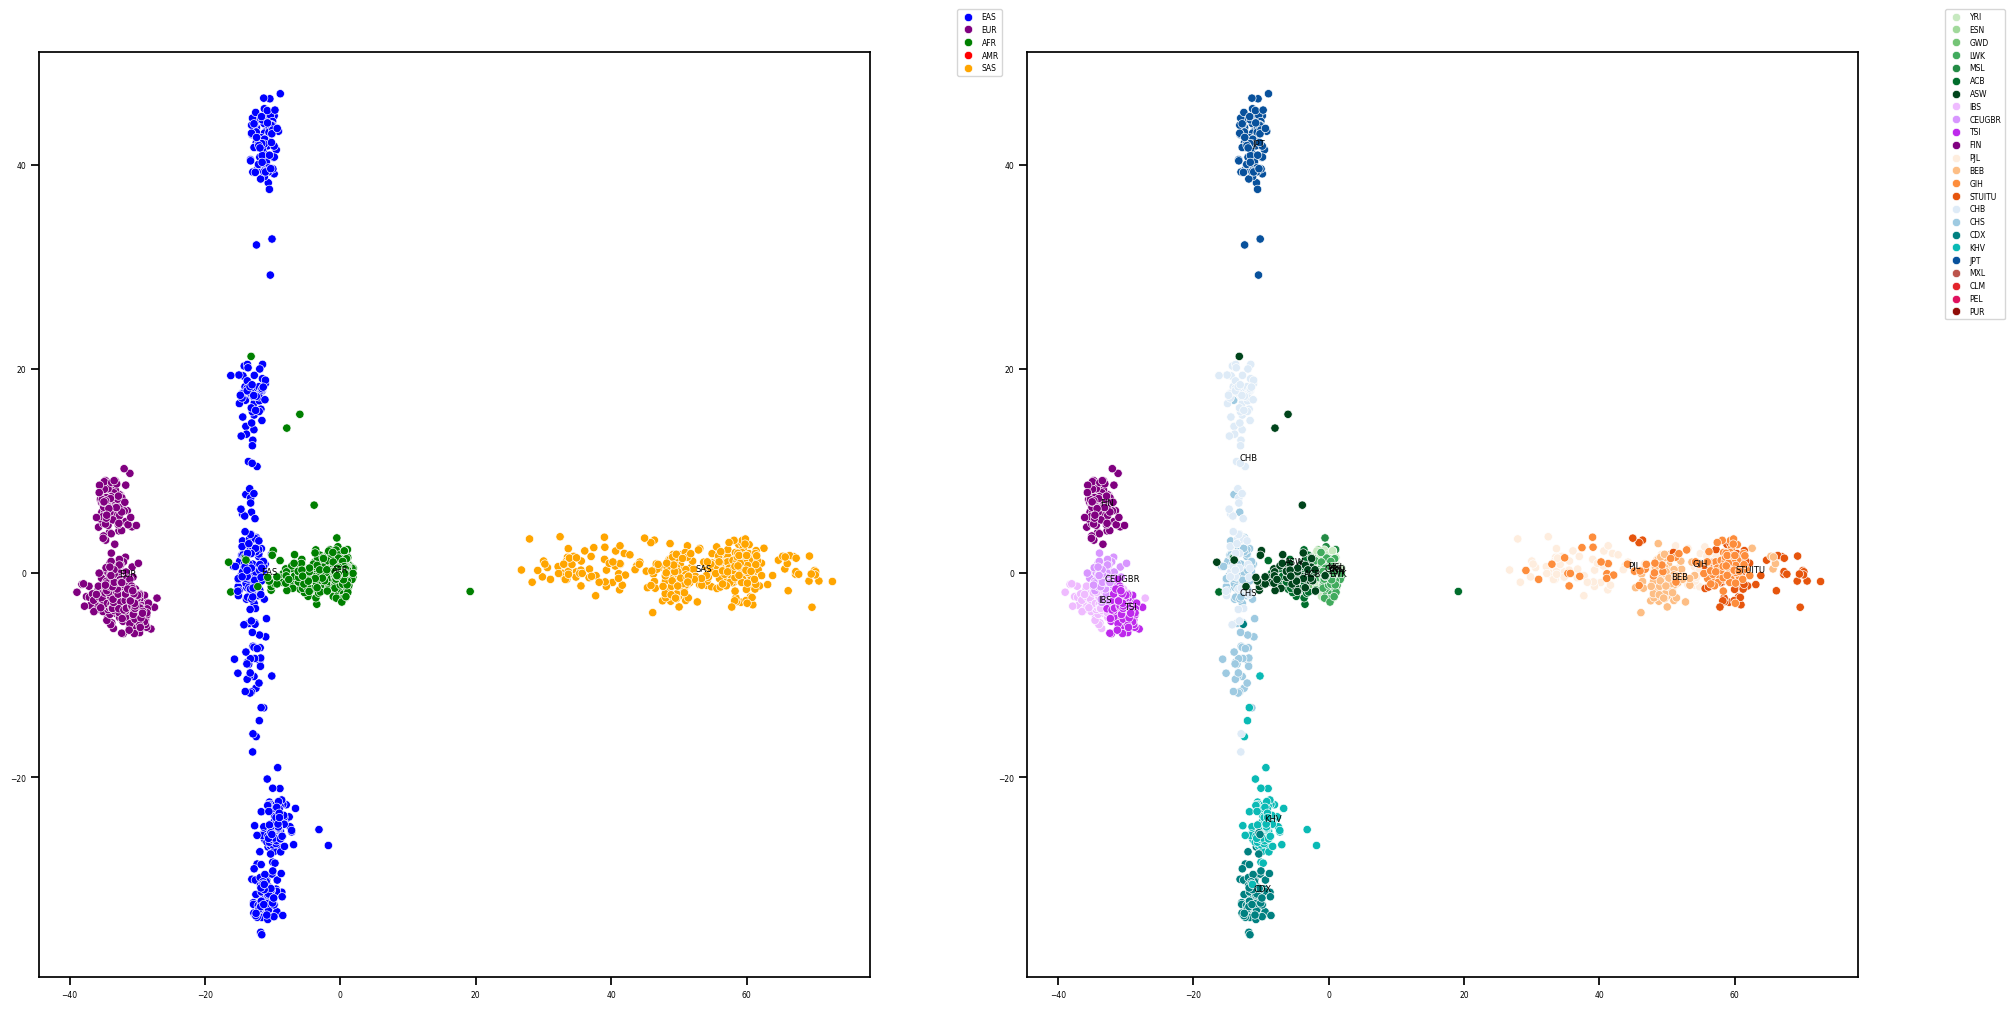

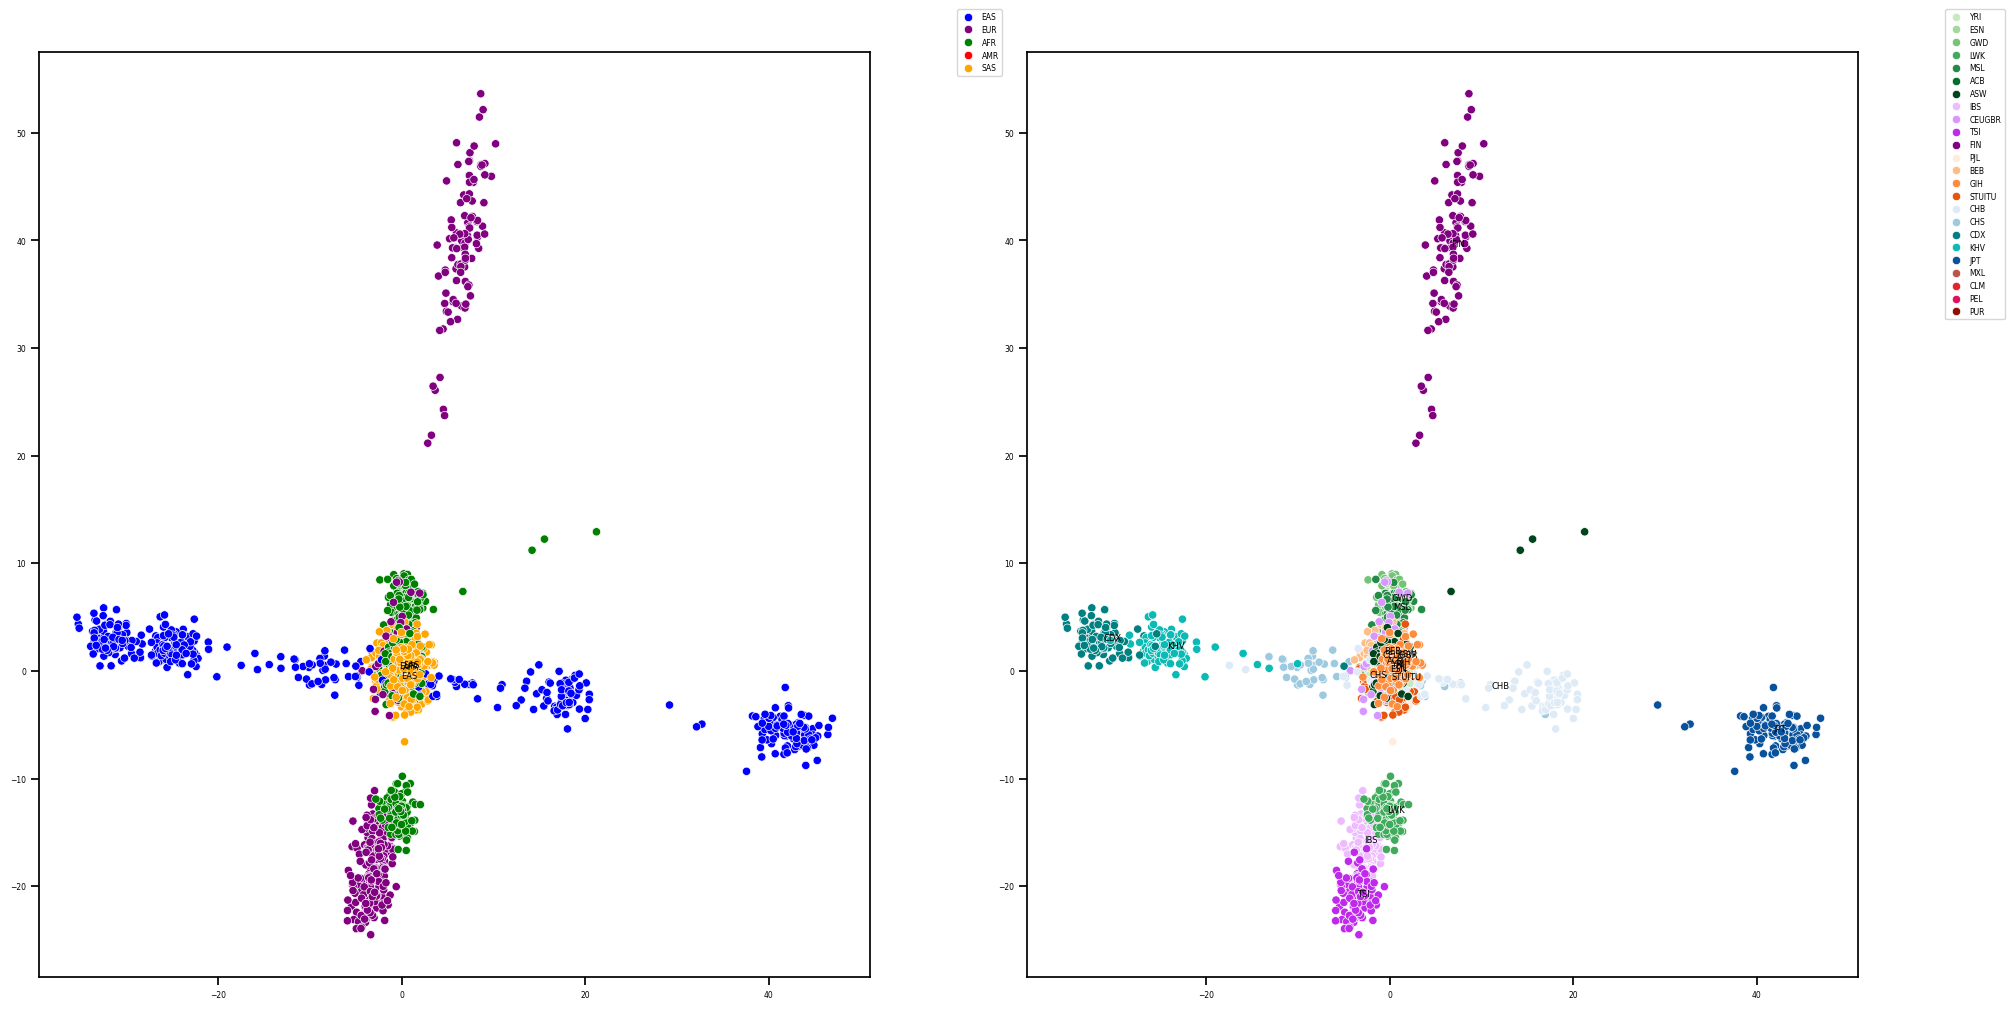

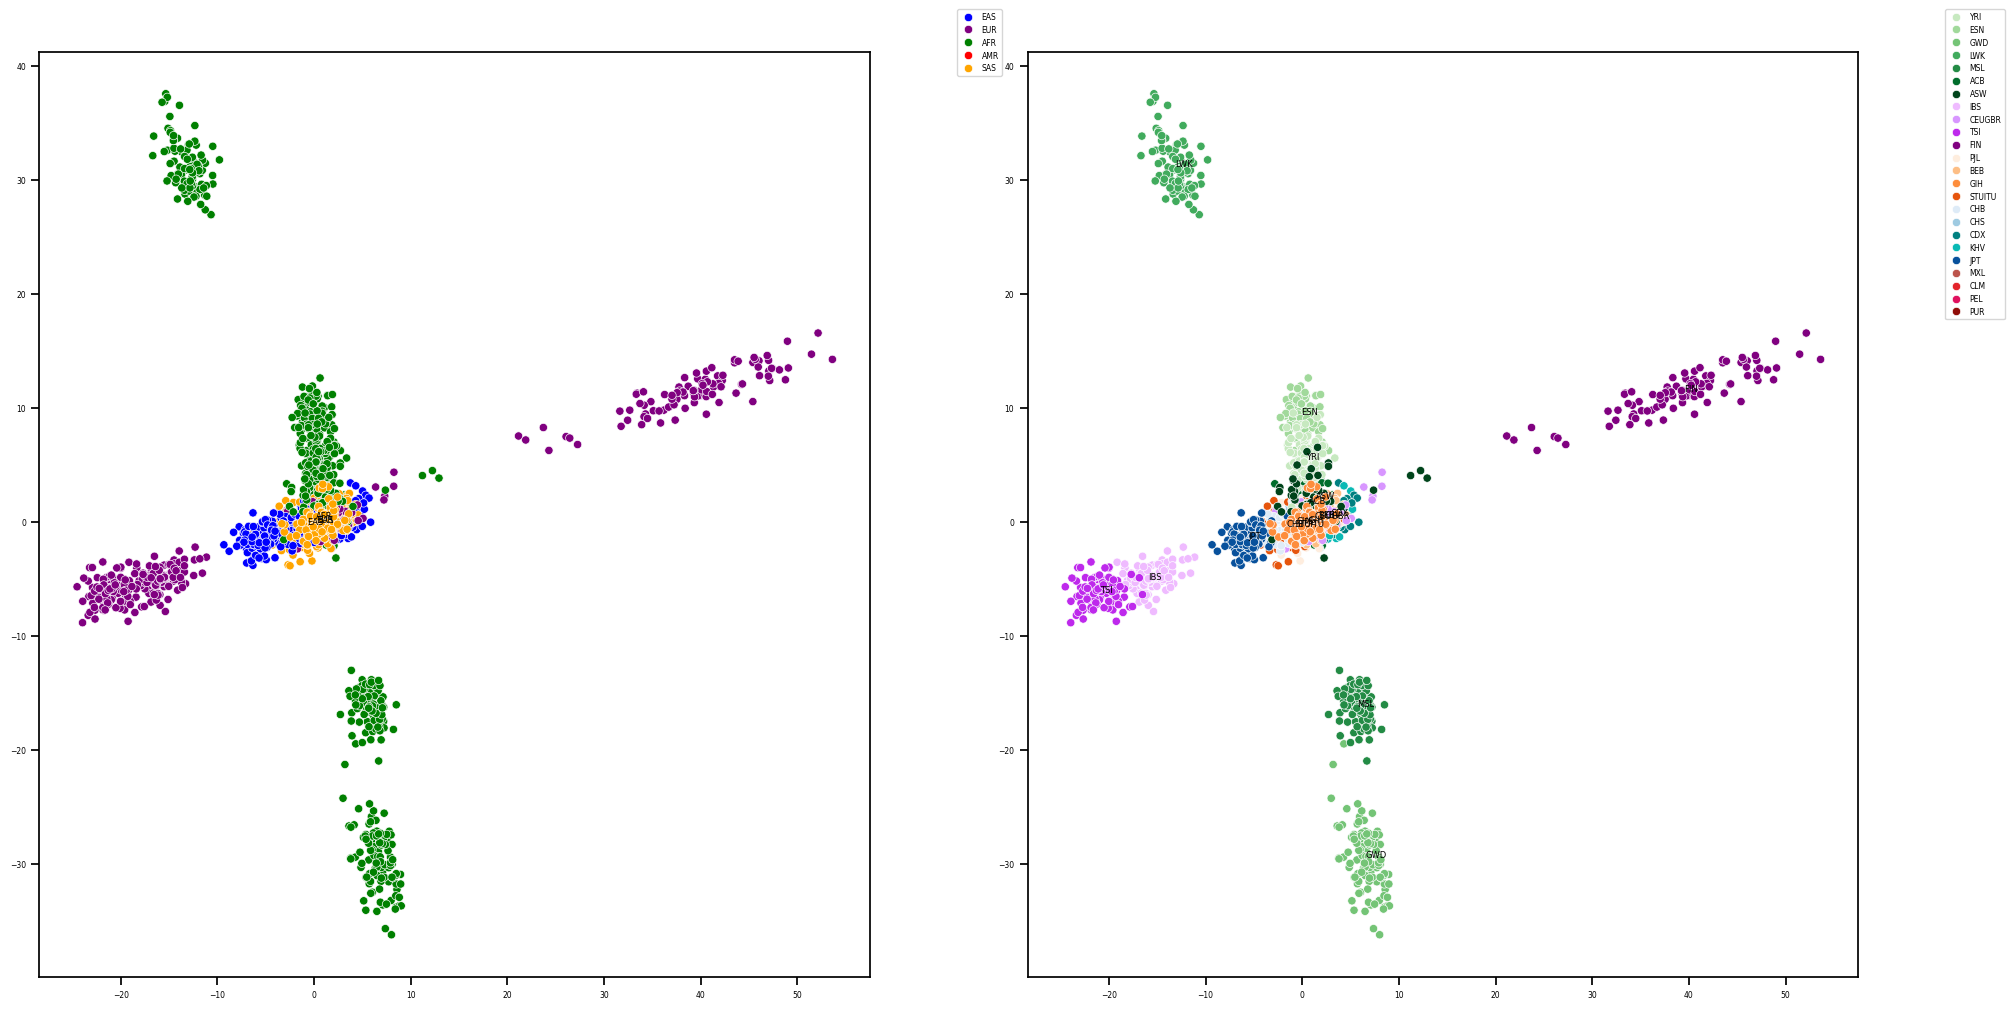

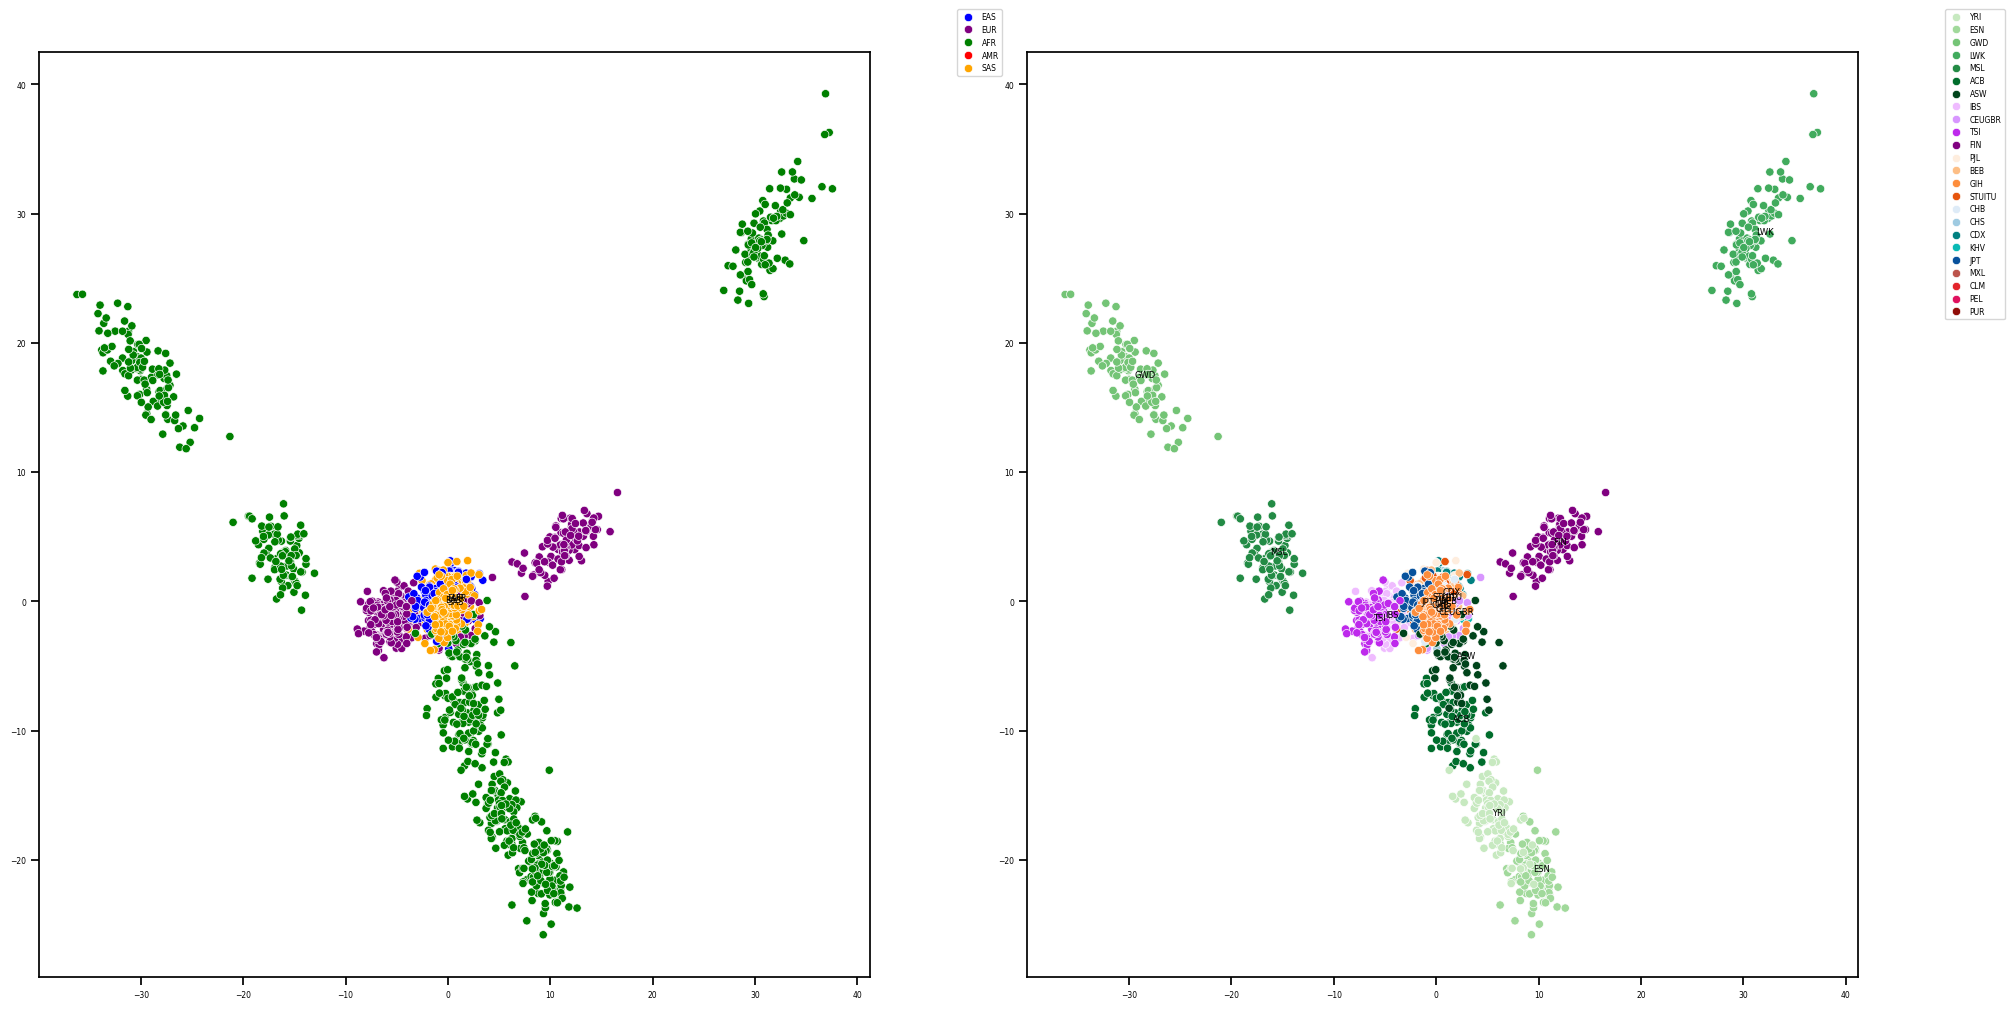

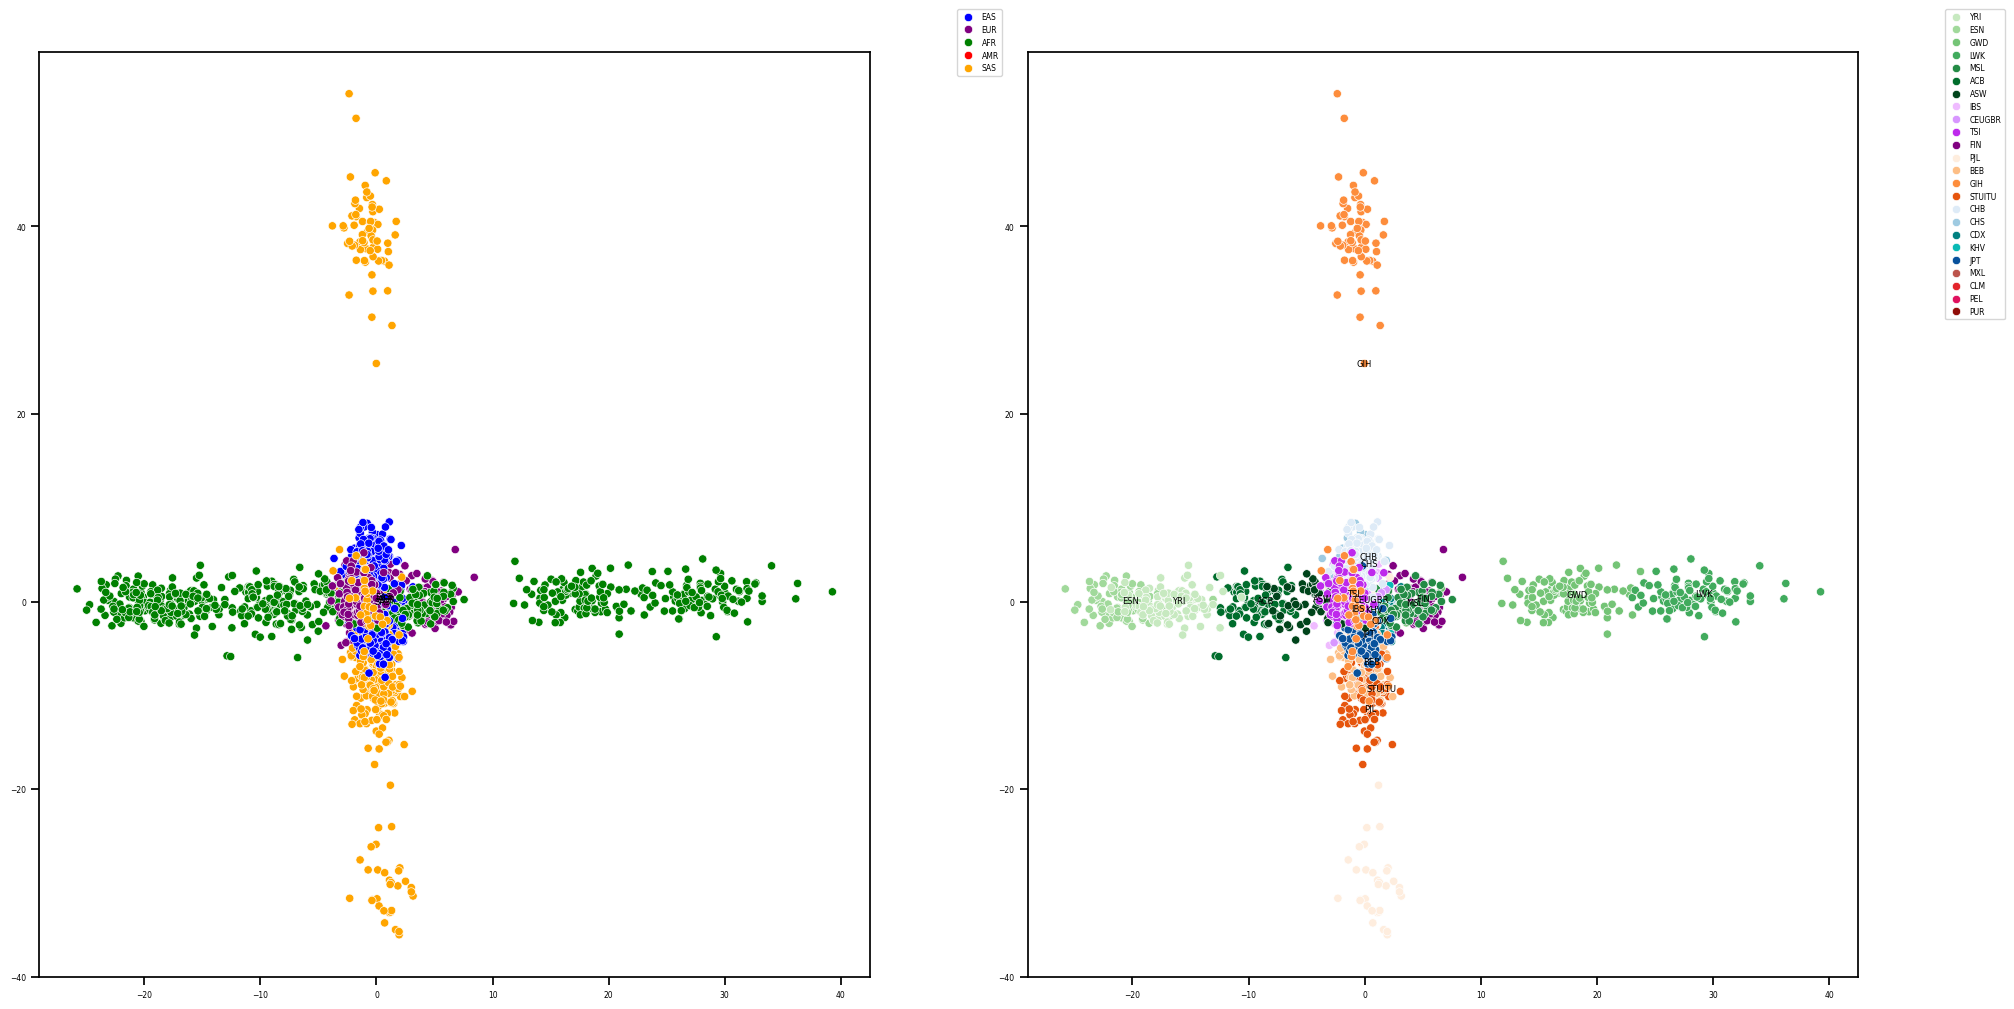

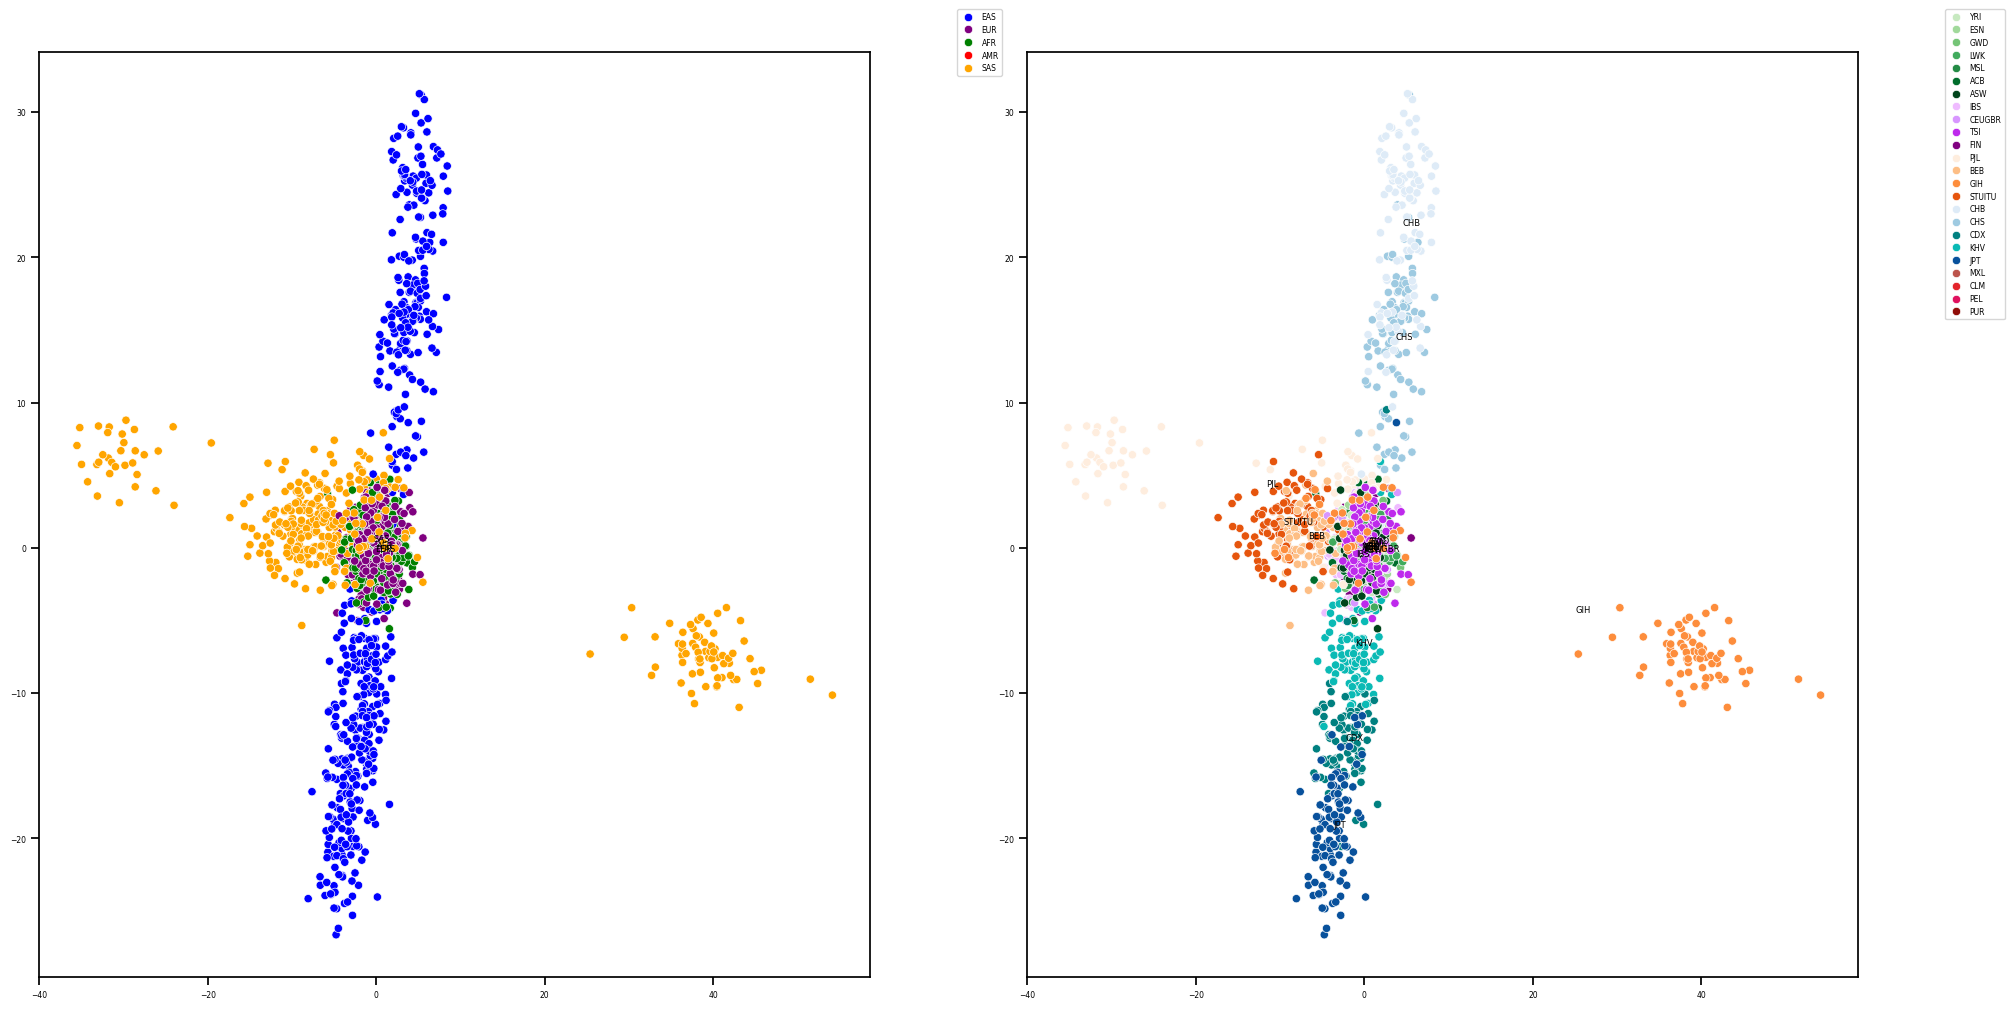

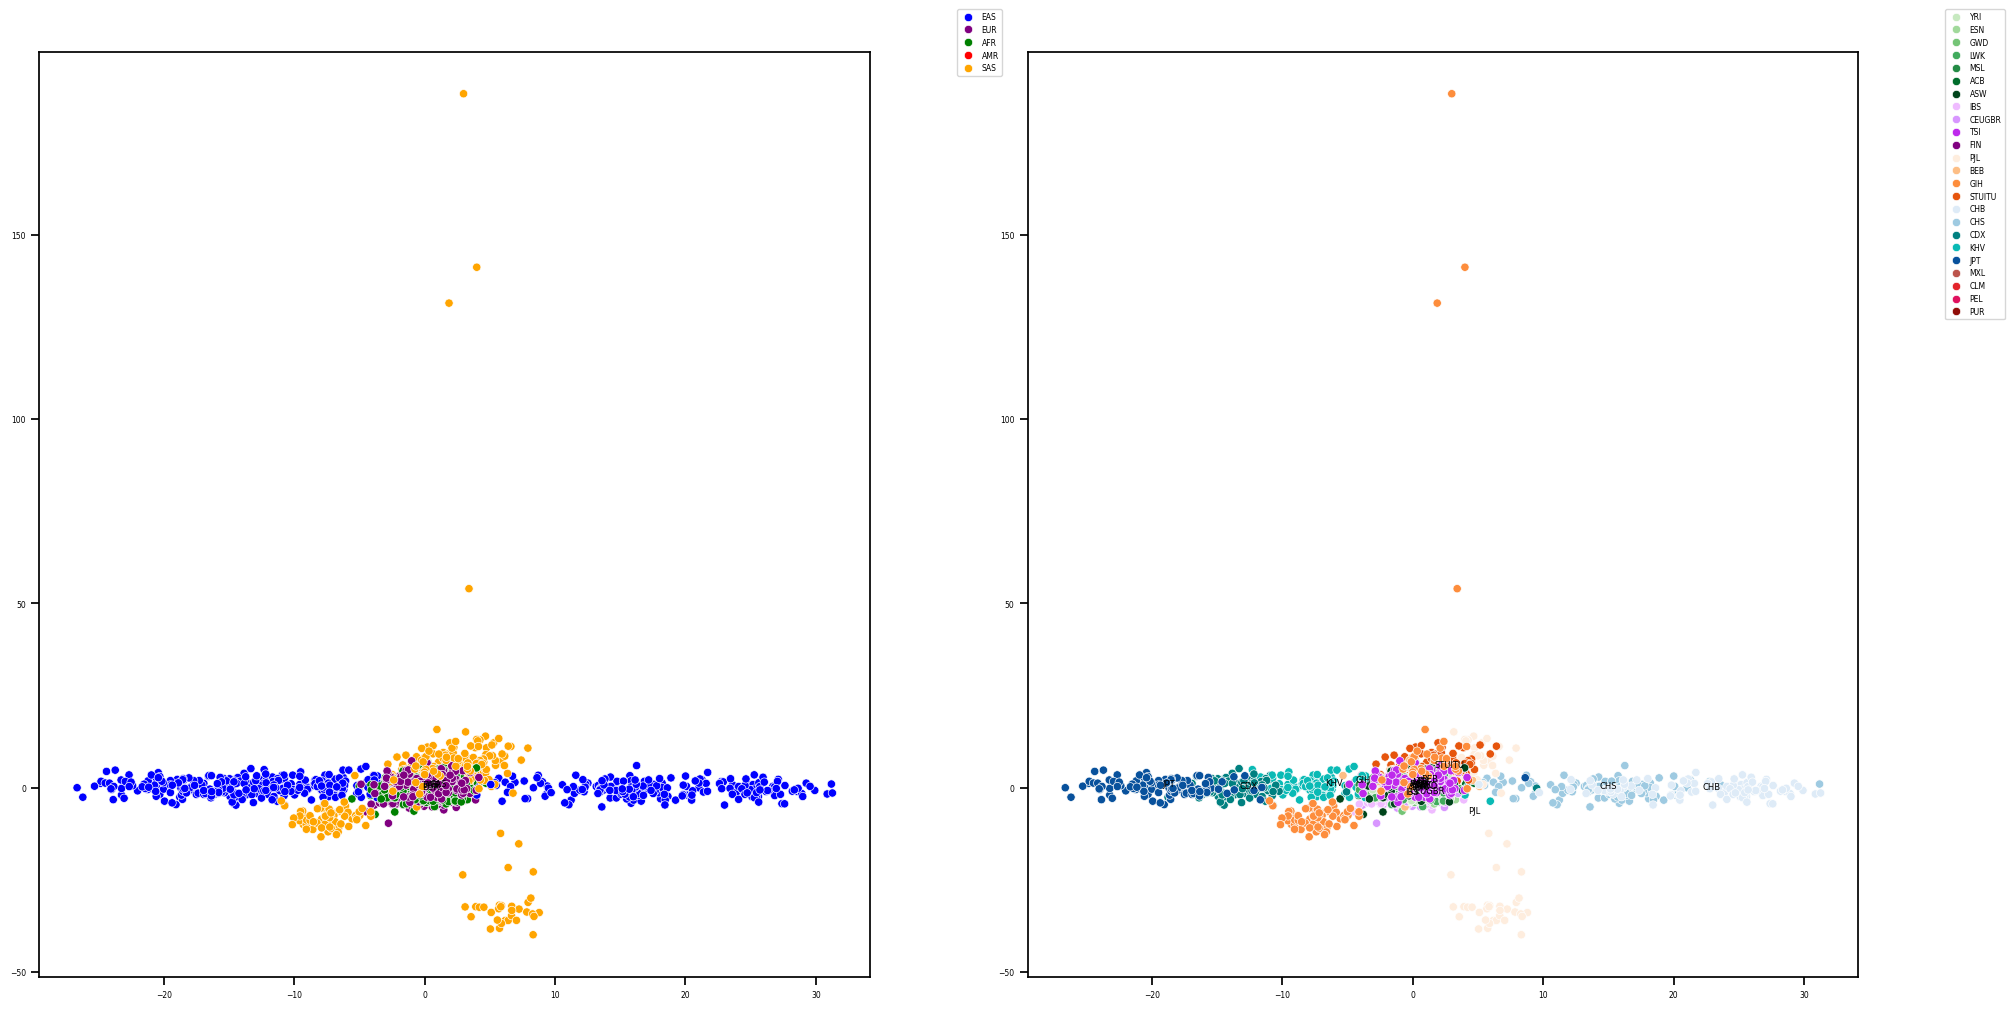

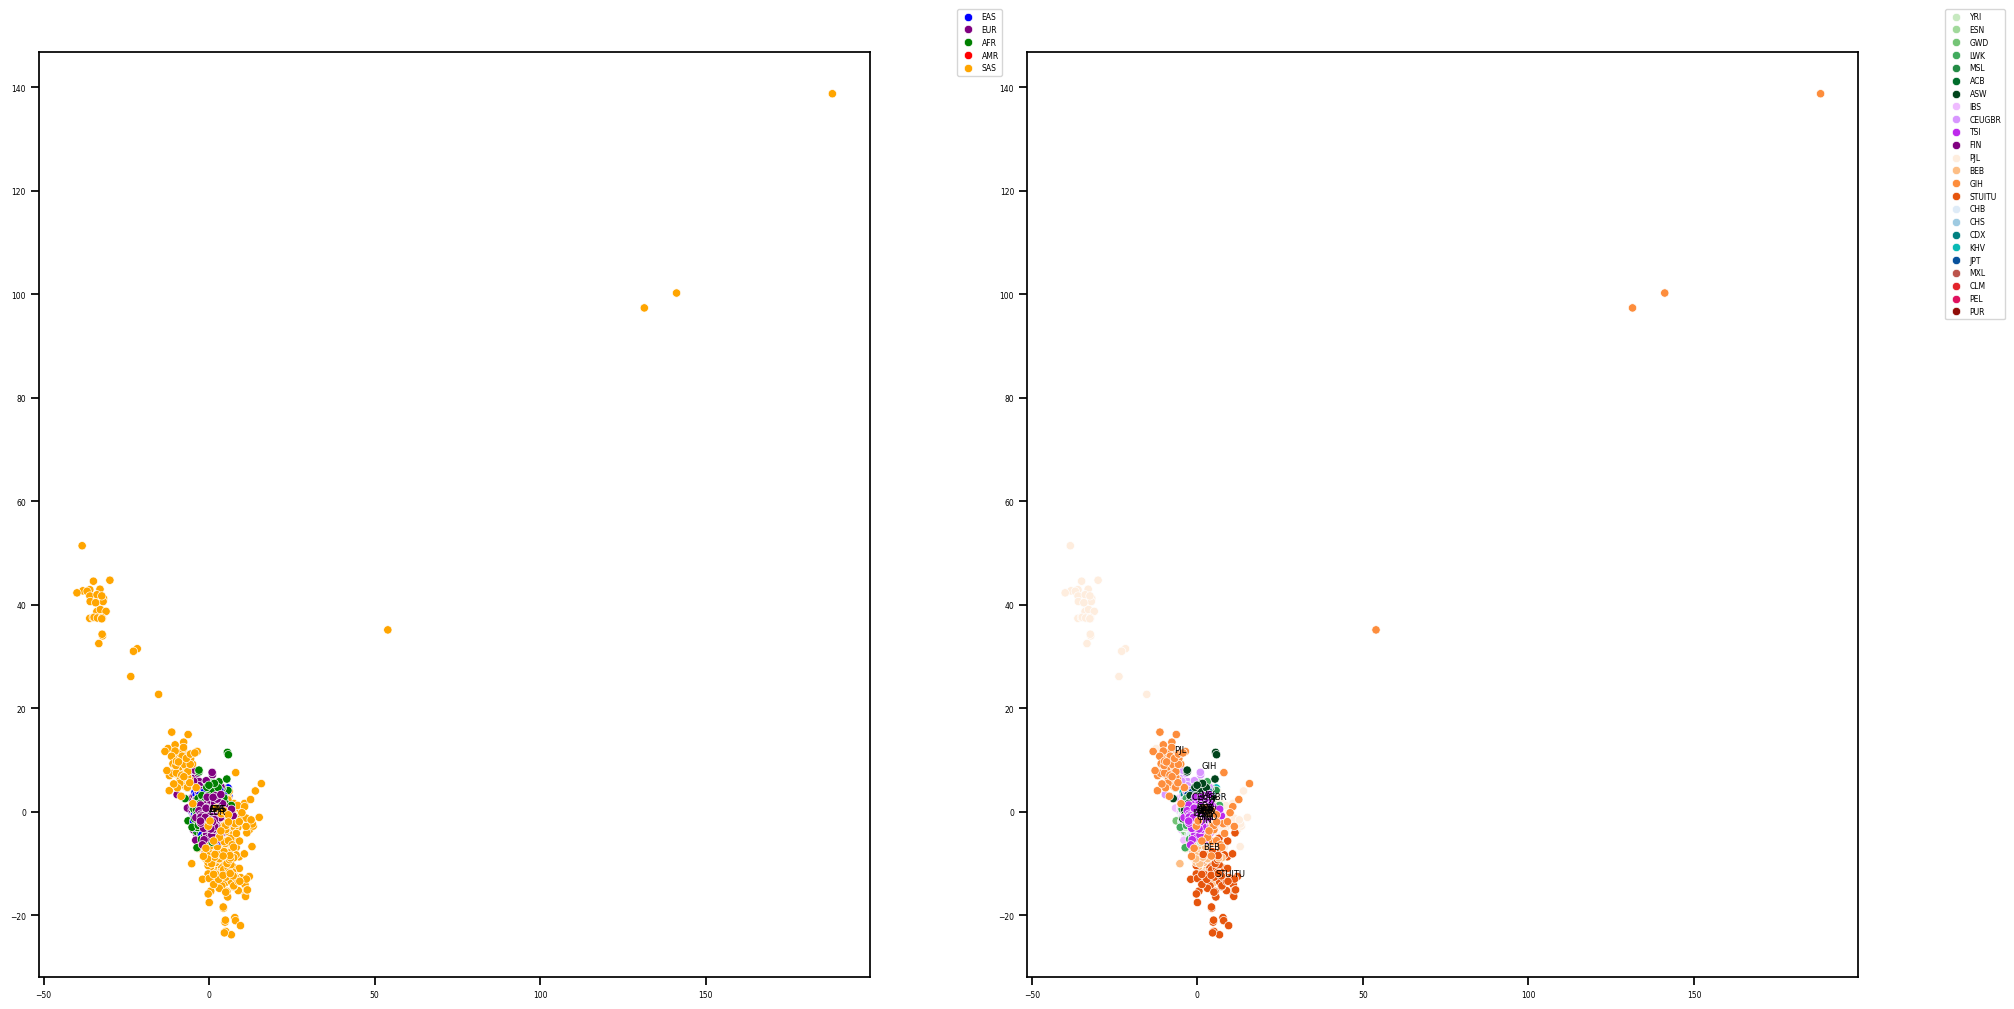

In [10]:
for comp in range(10):
# initial 2D phate embedding
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    plot_embeddings_1000G_labels(pca_input[:,comp:(comp+2)], 
                                 np.array(label_with_superpop_names), 
                                 mappings.pop_pallette_1000G_coarse,
                                 mappings.label_order_1000G_coarse,
                                 ax[0])
    plot_embeddings_1000G_labels(pca_input[:,comp:(comp+2)], 
                                 np.array(label_with_names),
                                 mappings.pop_pallette_1000G_fine,
                                 mappings.label_order_1000G_fine,
                                 ax[1])
    plt.tight_layout()

In [11]:
phate_operator42 = phate.PHATE(random_state=42, n_pca=None)
phate_operator42.fit(pca_input)
phate_emb42 = phate_operator42.transform()

Running PHATE on 1975 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.23 seconds.
  Calculating affinities...
  Calculated affinities in 0.16 seconds.
Calculated graph and diffusion operator in 0.42 seconds.
Calculating optimal t...
  Automatically selected t = 11
Calculated optimal t in 3.23 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.67 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.35 seconds.


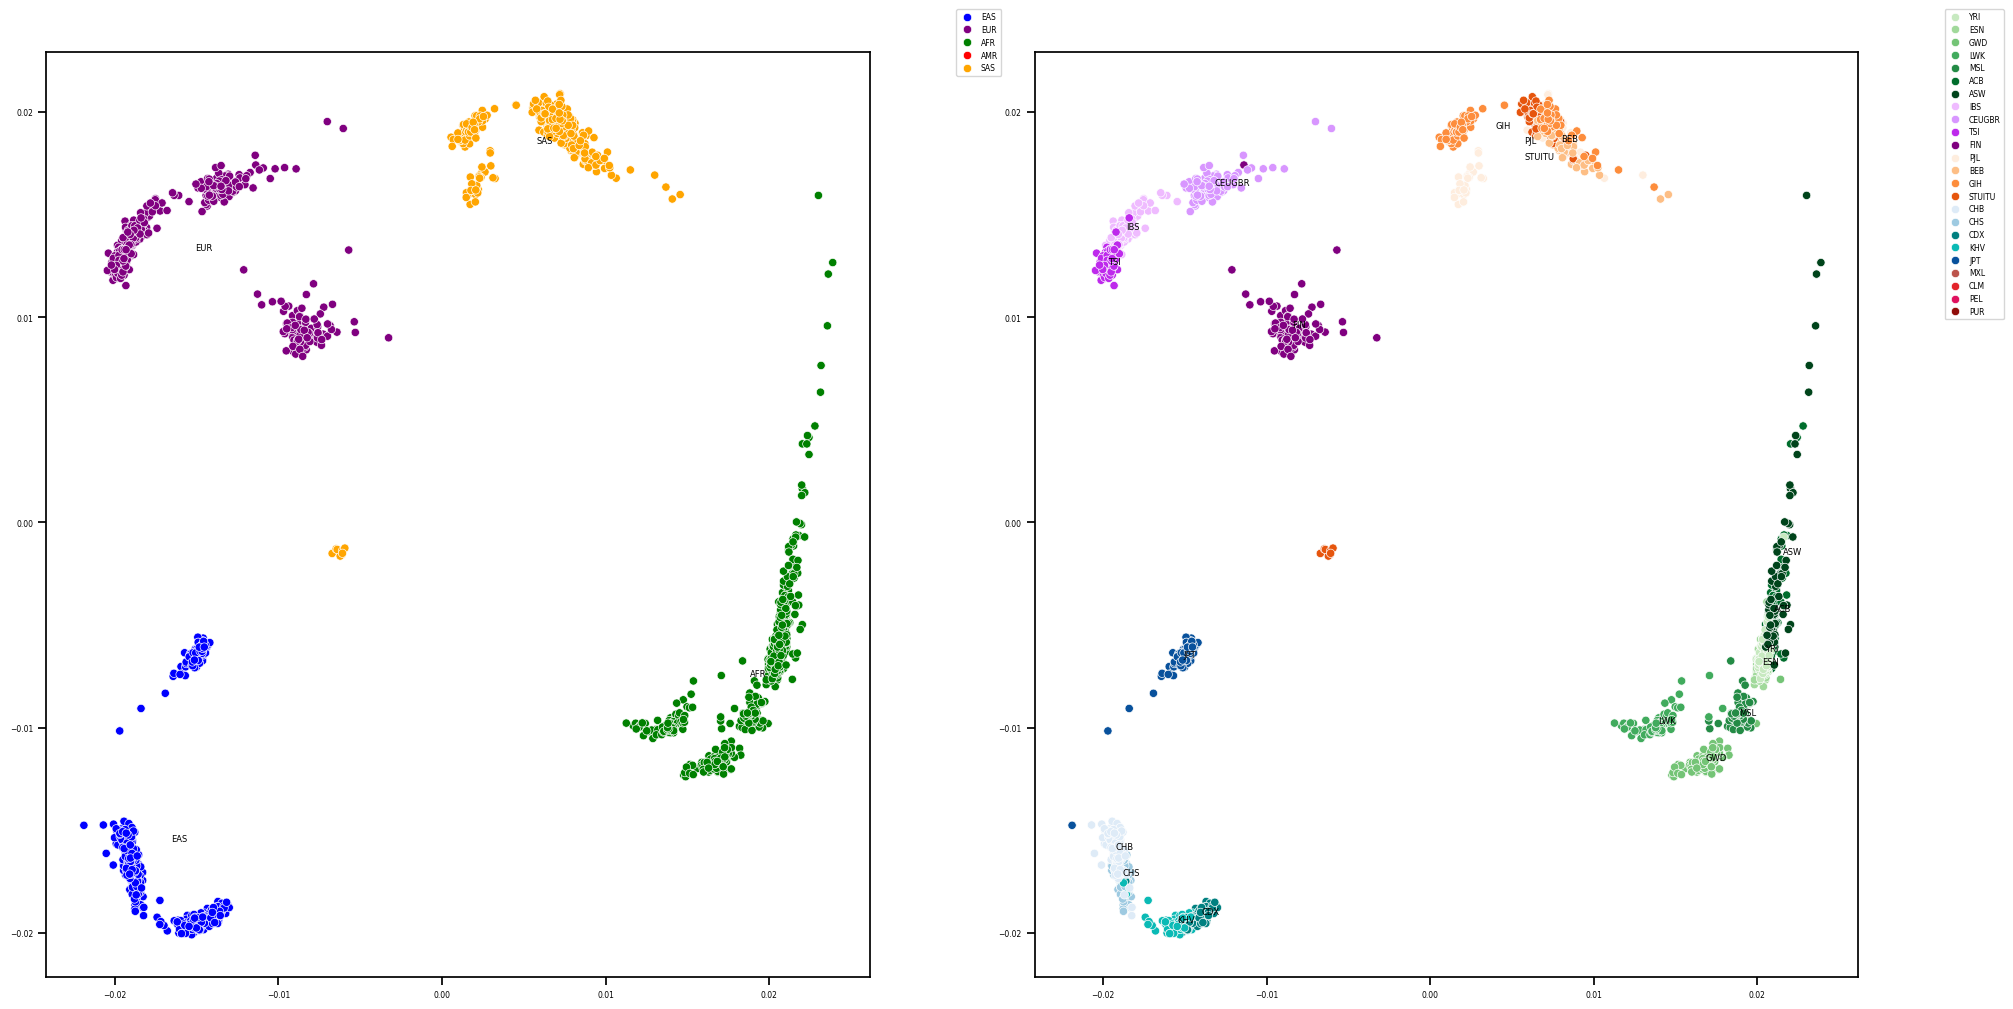

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_embeddings_1000G_labels(phate_emb42, 
                             np.array(label_with_superpop_names), 
                             mappings.pop_pallette_1000G_coarse,
                             mappings.label_order_1000G_coarse,
                             ax[0])
plot_embeddings_1000G_labels(phate_emb42, 
                             np.array(label_with_names),
                             mappings.pop_pallette_1000G_fine,
                             mappings.label_order_1000G_fine,
                             ax[1])
plt.tight_layout()